Section 1: Load the needed libraries

In [12]:
import networkx as nx
import pandas as pd
from pathlib import Path
from networkx.algorithms import community
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

projected_dir = Path("../data/networks/projected")
output_dir = Path("../data/results")
output_dir.mkdir(parents=True, exist_ok=True)

repos = ["scikit-learn", "pytorch", "kubernetes", "apache-spark"]
phases = ["pre", "during", "post"]




Section 2: Create the Global Metrics

In [13]:
def calculate_metrics(G):
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_clustering": nx.average_clustering(G),
    }

    # Modularity using Louvain if possible
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    except ImportError:
        modularity = None
    metrics["modularity"] = modularity

    return metrics


global_results = []

for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if not graph_path.exists():
            print(f"Missing: {graph_path}")
            continue

        G = nx.read_gml(graph_path)
        print(f"Loaded graph: {repo} ({phase}) with {G.number_of_nodes()} nodes")

        # Global metrics
        gm = calculate_metrics(G)
        gm["repo"] = repo
        gm["phase"] = phase

        global_results.append(gm)

global_df = pd.DataFrame(global_results)
global_df.to_csv(output_dir / "global_metrics.csv", index=False)
global_df


Loaded graph: scikit-learn (pre) with 95 nodes
Loaded graph: scikit-learn (during) with 131 nodes
Loaded graph: scikit-learn (post) with 35 nodes
Loaded graph: pytorch (pre) with 359 nodes
Loaded graph: pytorch (during) with 803 nodes
Loaded graph: pytorch (post) with 365 nodes
Loaded graph: kubernetes (pre) with 1160 nodes
Loaded graph: kubernetes (during) with 1430 nodes
Loaded graph: kubernetes (post) with 423 nodes
Loaded graph: apache-spark (pre) with 172 nodes
Loaded graph: apache-spark (during) with 202 nodes
Loaded graph: apache-spark (post) with 76 nodes


,num_nodes,num_edges,density,avg_clustering,modularity,repo,phase
0,95,138,0.030907,0.259662,0.469224,scikit-learn,pre
1,131,189,0.022196,0.200871,0.498959,scikit-learn,during
2,35,52,0.087395,0.146604,0.363343,scikit-learn,post
3,359,2498,0.038873,0.696226,0.241116,pytorch,pre
4,803,8090,0.025124,0.572704,0.408635,pytorch,during
5,365,4539,0.068328,0.661742,0.381133,pytorch,post
6,1160,18491,0.027507,0.672398,0.337938,kubernetes,pre
7,1430,18550,0.018155,0.661403,0.361694,kubernetes,during
8,423,4072,0.045623,0.652579,0.380824,kubernetes,post
9,172,388,0.026384,0.302493,0.612295,apache-spark,pre


Section 3: Create the Node Level Metrics

In [14]:
# Node-level metrics
node_results = []

for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if not graph_path.exists():
            continue

        G = nx.read_gml(graph_path)
        strength_dict = dict(G.degree(weight="weight"))
        degree_dict = dict(G.degree())
        betweenness_dict = nx.betweenness_centrality(G, weight="weight", normalized=True)

        for node in G.nodes():
            node_results.append({
                "repo": repo,
                "phase": phase,
                "node": node,
                "degree": degree_dict.get(node, 0),
                "strength": strength_dict.get(node, 0),
                "betweenness": betweenness_dict.get(node, 0)
            })

node_df = pd.DataFrame(node_results)
node_df.to_csv(output_dir / "node_metrics.csv", index=False)
node_df.head()


,repo,phase,node,degree,strength,betweenness
0,scikit-learn,pre,glemaitre,19,49,0.366125
1,scikit-learn,pre,vachanda,1,2,0.000000
2,scikit-learn,pre,reshamas,11,39,0.151224
3,scikit-learn,pre,mghah,1,2,0.000000
4,scikit-learn,pre,venkyyuvy,2,5,0.000000


Section 4: Summarize the Node Level Results

In [15]:


# Load the node metrics CSV file
node_metrics = pd.read_csv("../data/results/node_metrics.csv")

# Compute descriptive statistics per repository and phase
summary_stats = (
    node_metrics
    .groupby(["repo", "phase"])
    .agg({
        "degree": ["mean", "median", "max", "std"],
        "strength": ["mean", "median", "max", "std"],
        "betweenness": ["mean", "median", "max", "std"]
    })
    .reset_index()
)

# Flatten the multi-index columns
summary_stats.columns = ["_".join(col).strip("_") for col in summary_stats.columns]

# Save the summary as a CSV file
output_path = Path("../data/results/node_metrics_summary.csv")
summary_stats.to_csv(output_path, index=False)

# Optional: Preview the summary
summary_stats.head()


,repo,phase,degree_mean,degree_median,degree_max,degree_std,strength_mean,strength_median,strength_max,strength_std,betweenness_mean,betweenness_median,betweenness_max,betweenness_std
0,apache-spark,during,3.346535,2.0,26,4.213071,11.366337,5.0,119,17.538145,0.014775,0.000000,0.259322,0.036587
1,apache-spark,post,2.710526,2.0,12,2.398976,9.368421,6.0,64,11.711922,0.027064,0.000000,0.335075,0.055883
2,apache-spark,pre,4.511628,2.0,48,6.311123,20.488372,5.0,255,38.310441,0.012311,0.000172,0.195813,0.030148
3,kubernetes,during,25.944056,6.0,617,55.216030,211.436364,15.0,13470,735.752436,0.001331,0.000064,0.068712,0.004380
4,kubernetes,post,19.252955,7.0,184,28.648298,119.905437,21.0,2246,257.023005,0.004225,0.000399,0.080597,0.009435


Section 5: Visualization

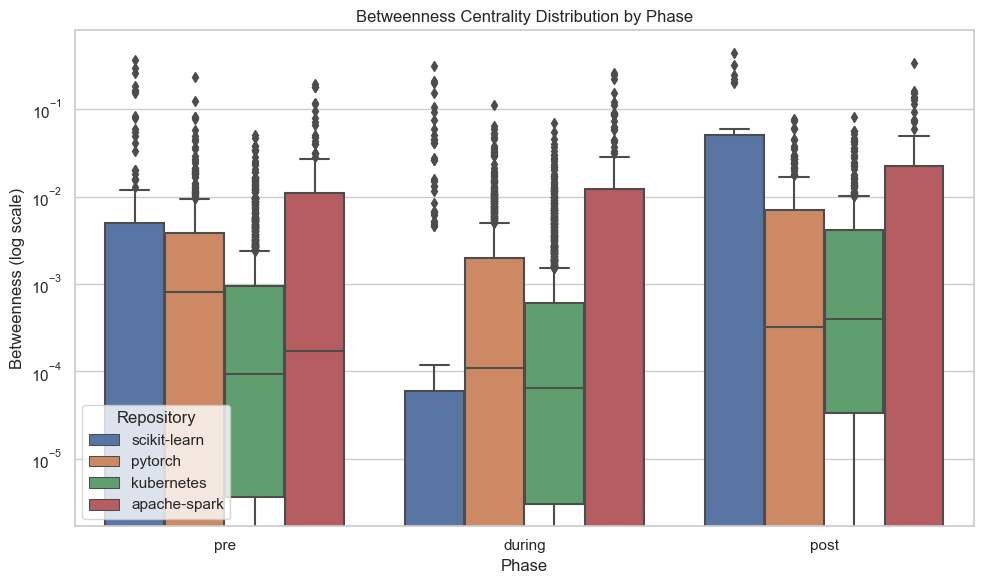

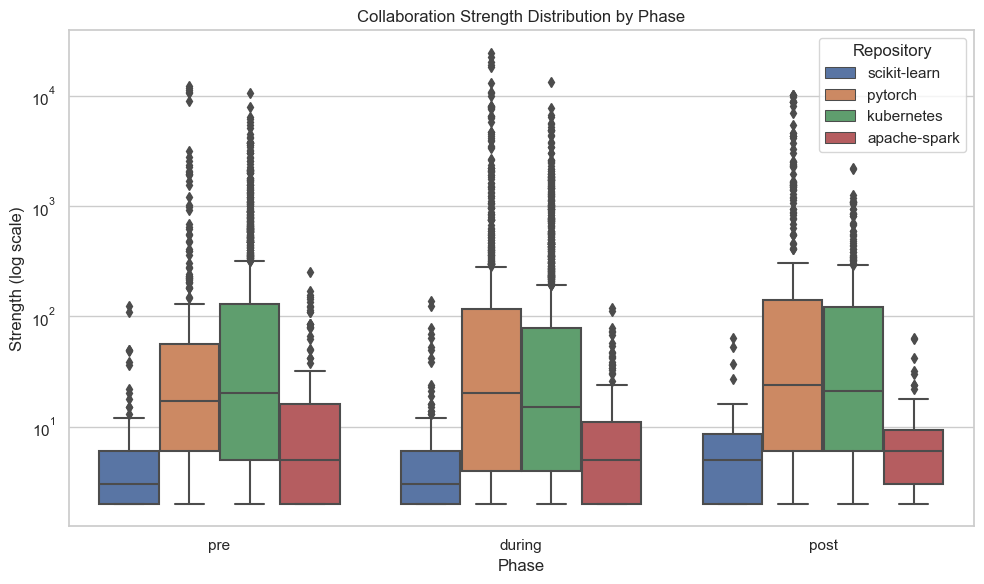

In [16]:

# Load your node metrics CSV
df = pd.read_csv("../data/results/node_metrics.csv")  # Adjust path if needed

# Set seaborn style
sns.set(style="whitegrid")

# Ensure columns are lowercase for consistency
df.columns = [col.lower() for col in df.columns]

# Plot 1: Betweenness Centrality by Repository and Phase
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="phase", y="betweenness", hue="repo")
plt.yscale("log")  # Betweenness is usually skewed
plt.title("Betweenness Centrality Distribution by Phase")
plt.xlabel("Phase")
plt.ylabel("Betweenness (log scale)")
plt.legend(title="Repository")
plt.tight_layout()
plt.show()

# Plot 2: Strength by Repository and Phase
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="phase", y="strength", hue="repo")
plt.yscale("log")  # Often heavy-tailed as well
plt.title("Collaboration Strength Distribution by Phase")
plt.xlabel("Phase")
plt.ylabel("Strength (log scale)")
plt.legend(title="Repository")
plt.tight_layout()
plt.show()


Section 6: Top Contributor Visualizations

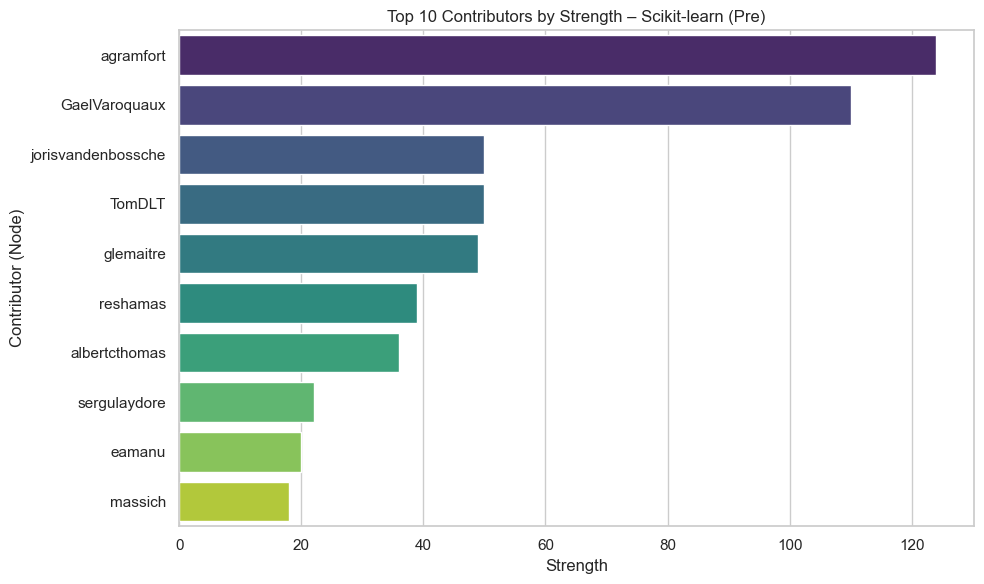

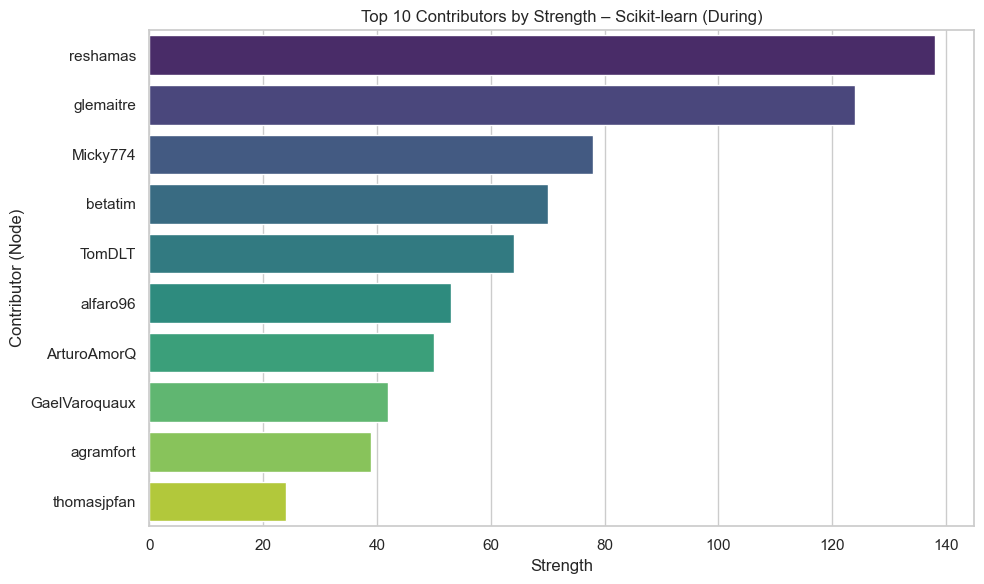

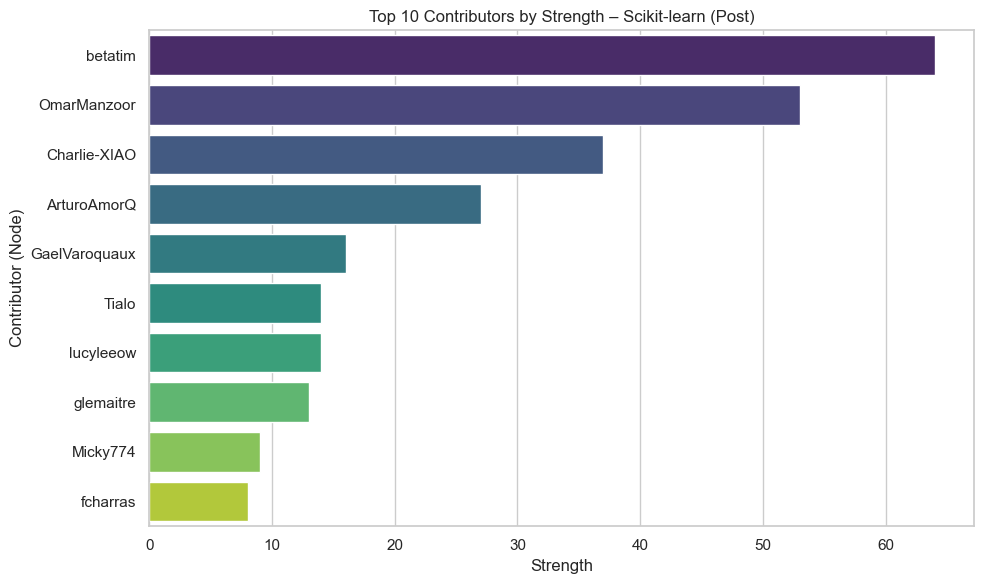

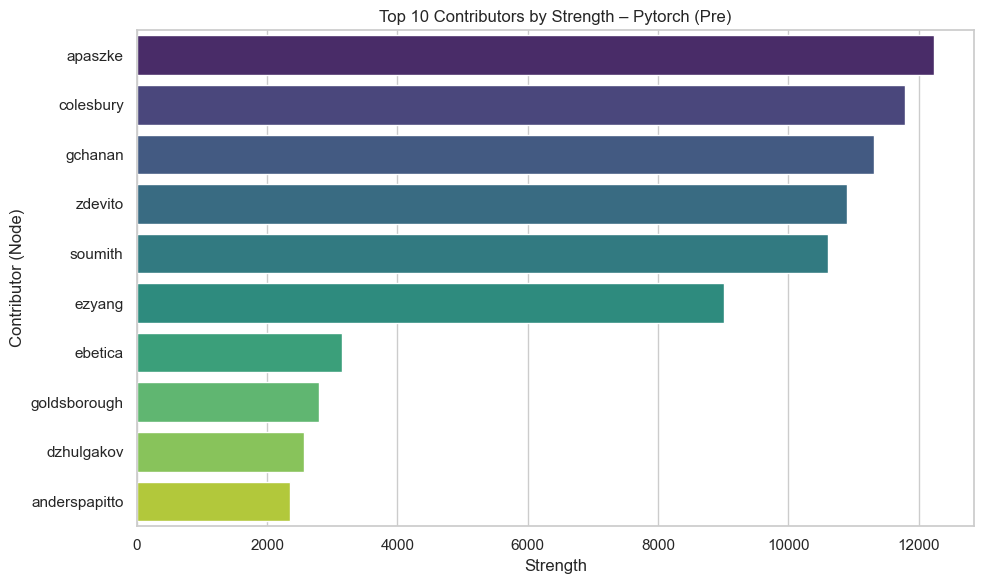

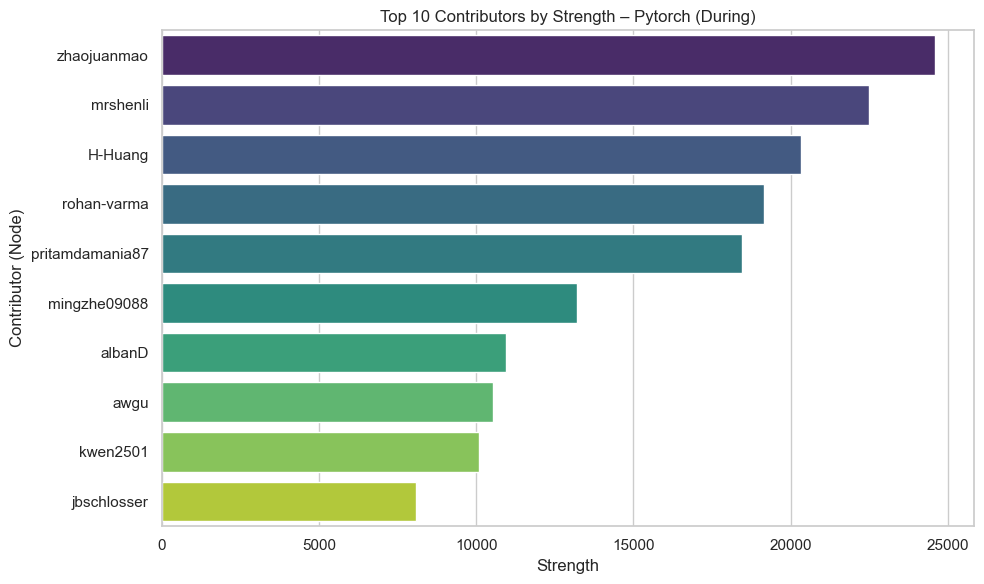

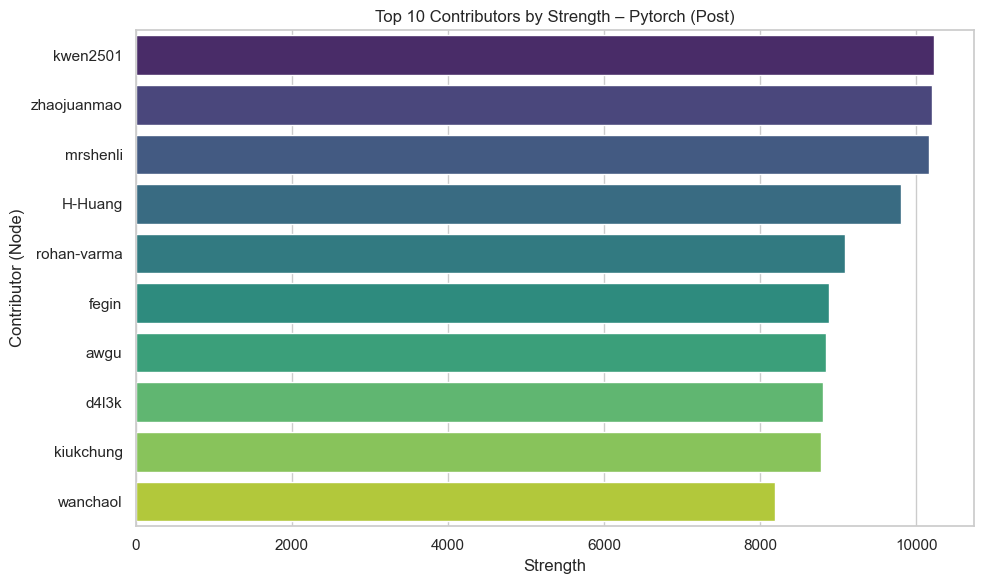

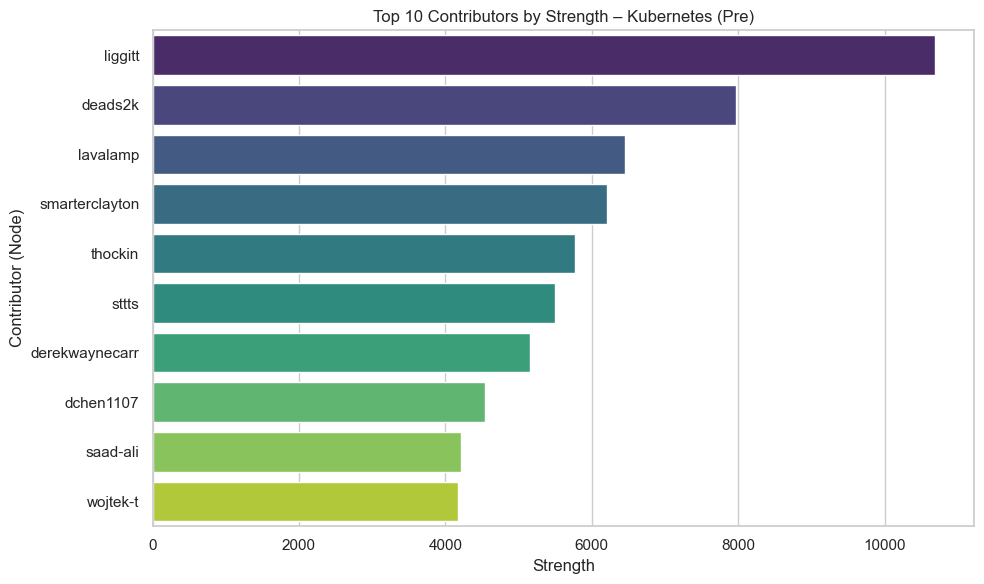

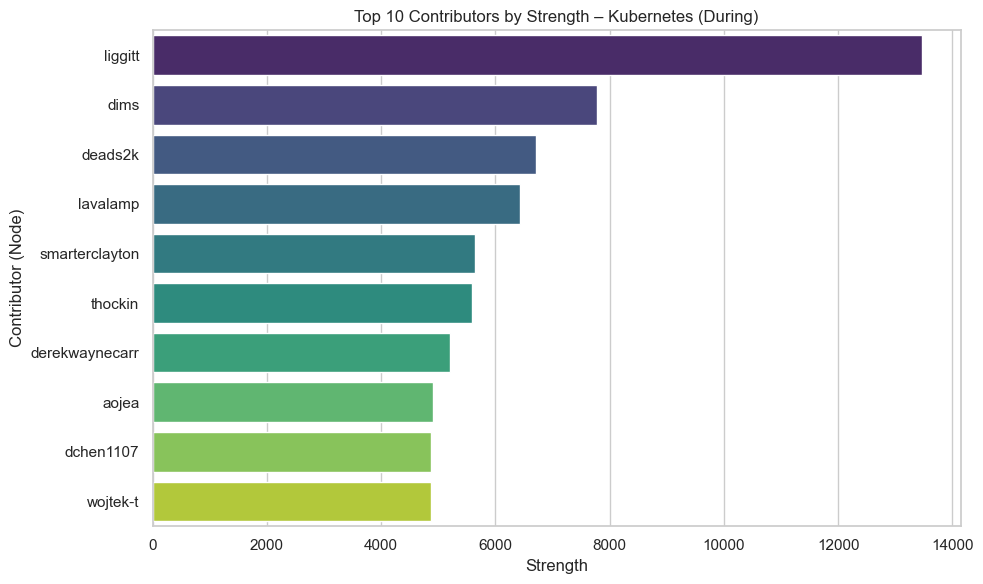

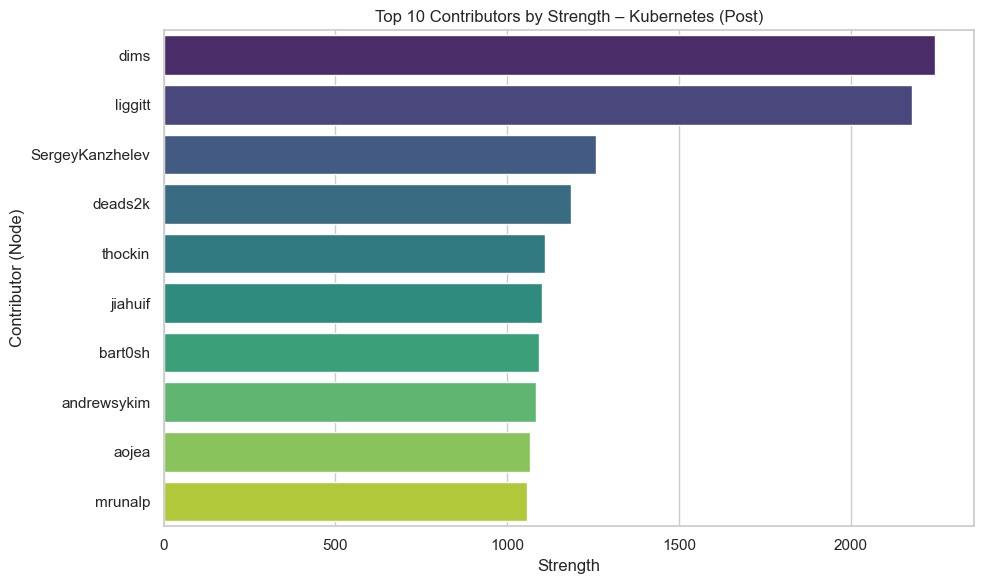

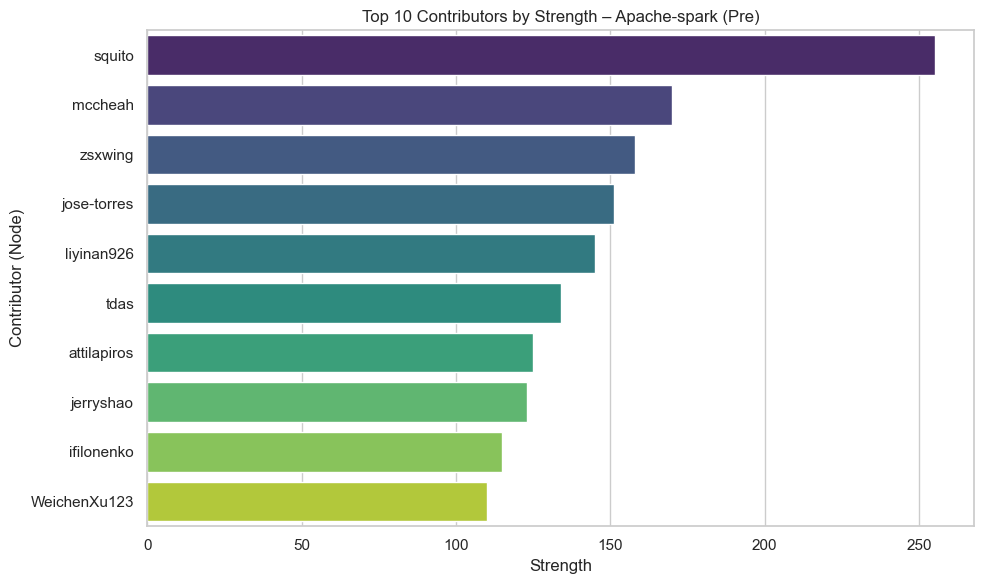

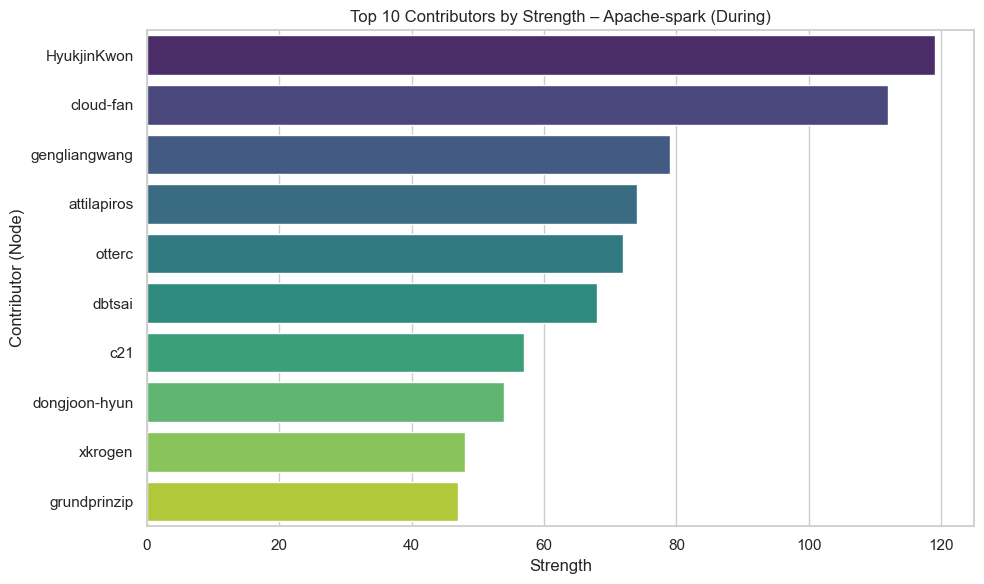

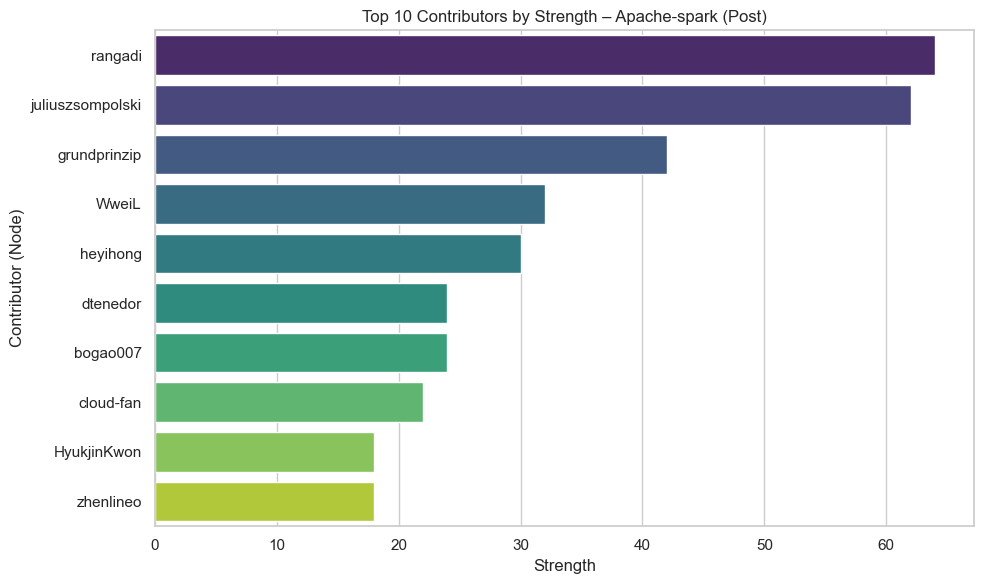

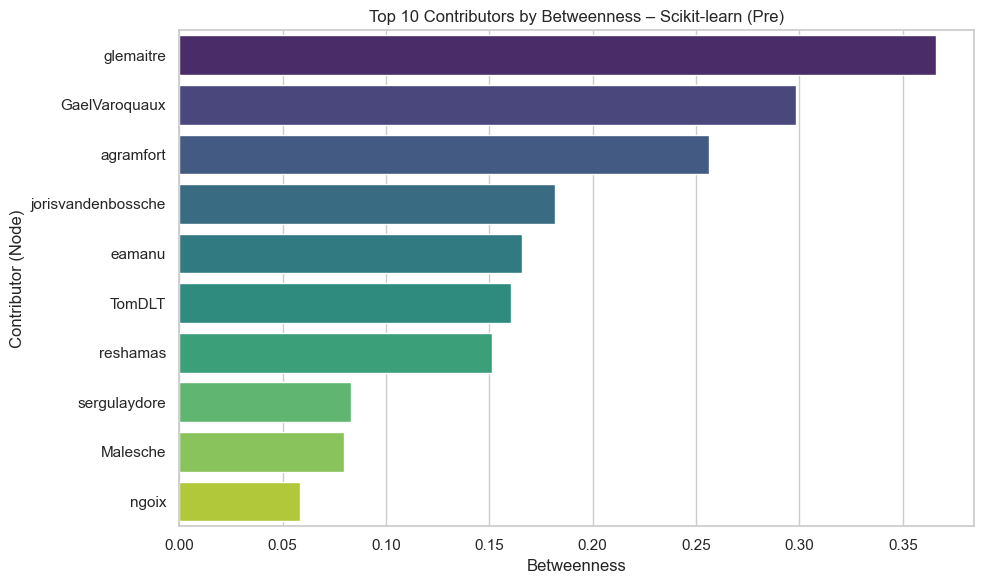

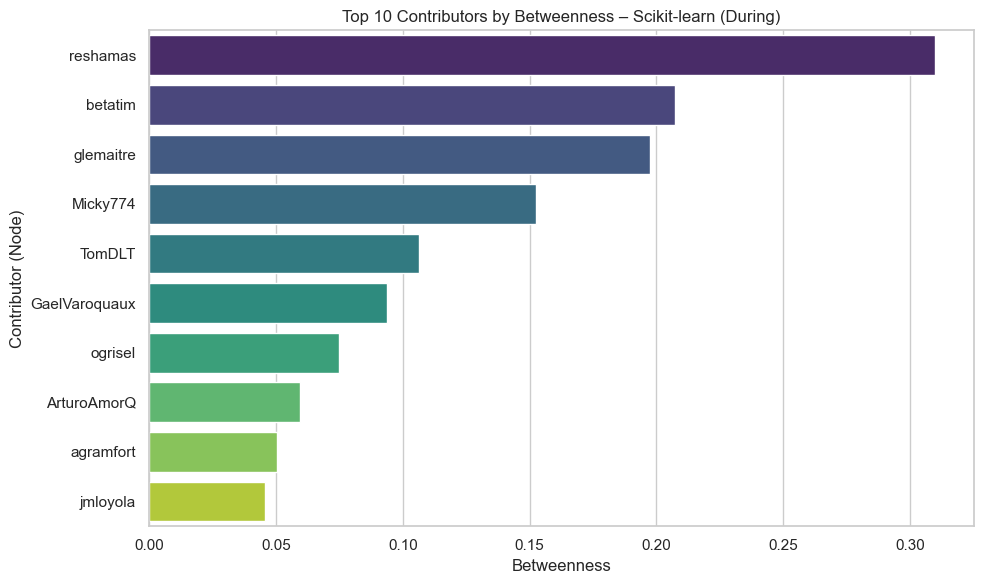

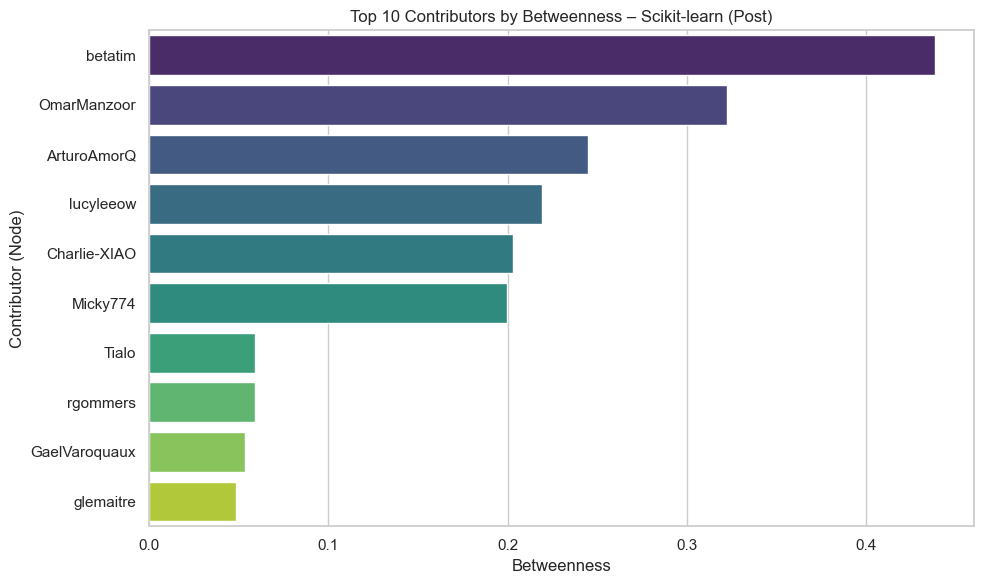

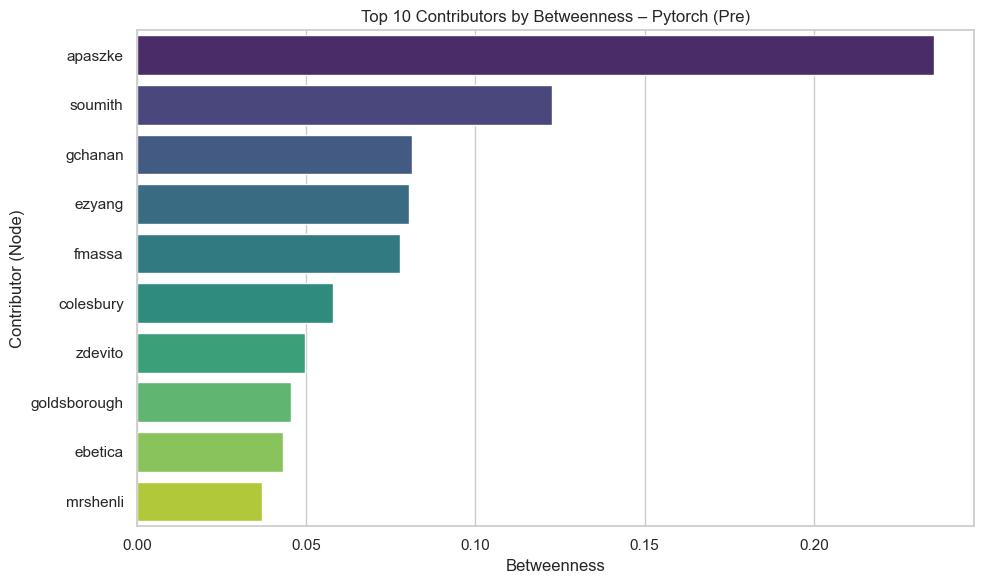

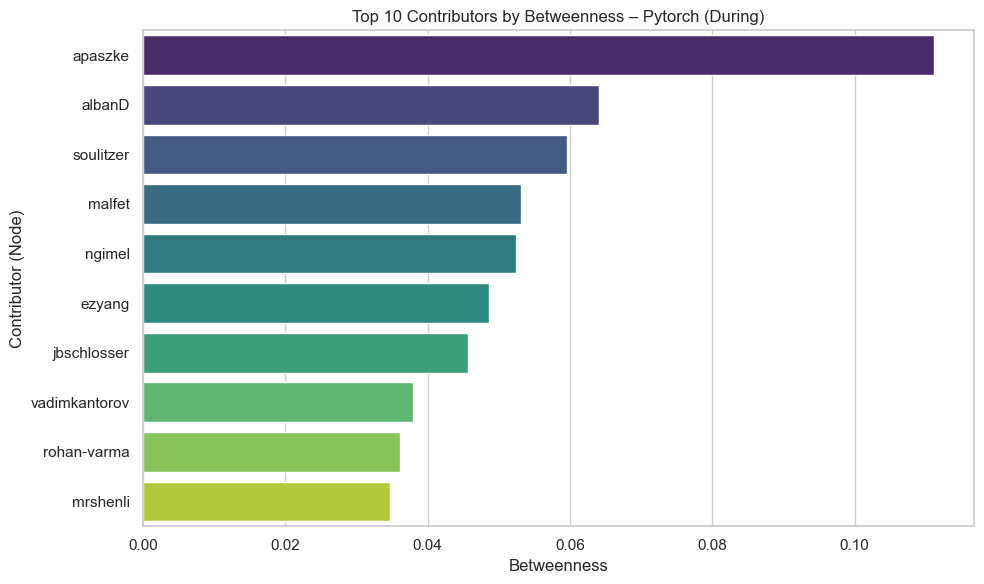

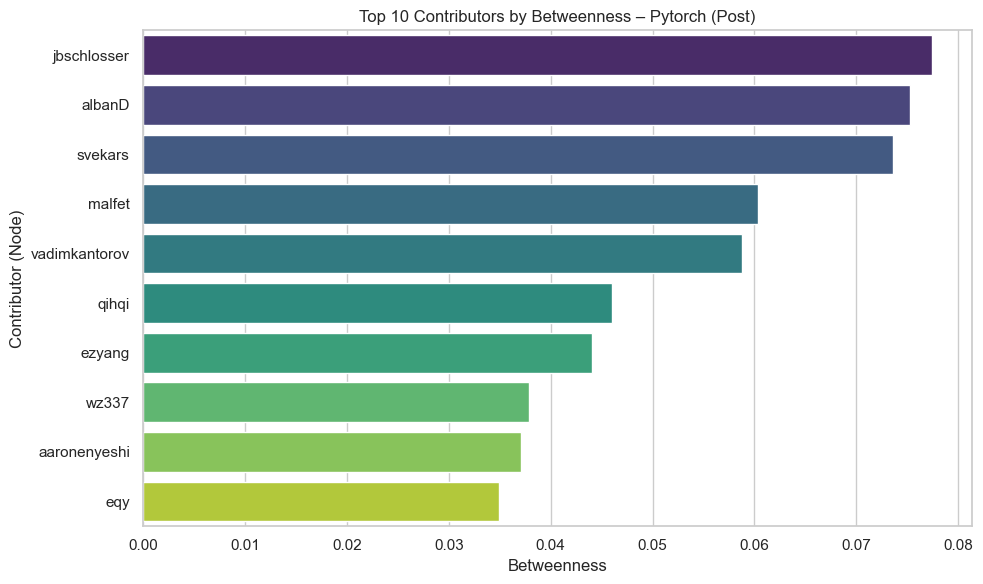

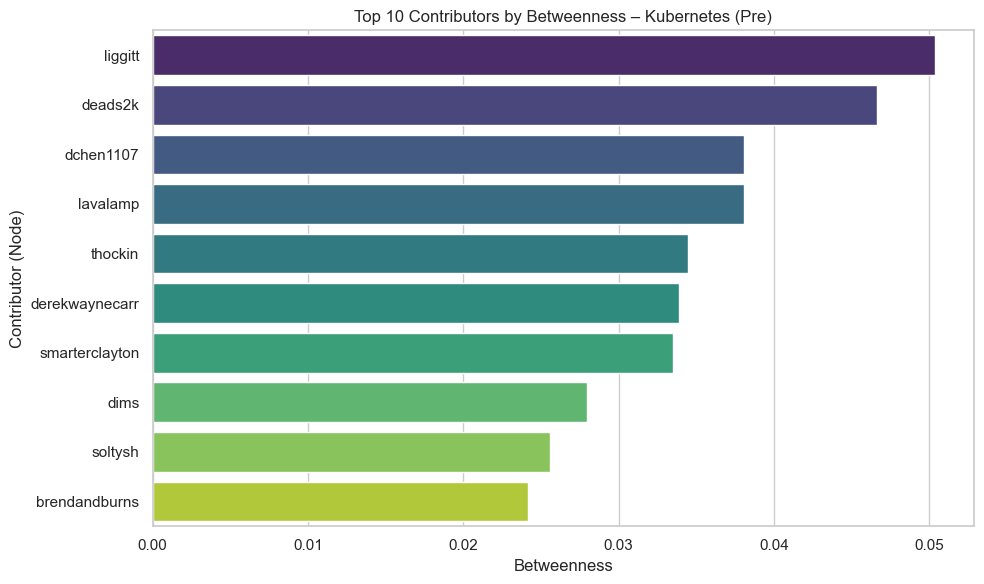

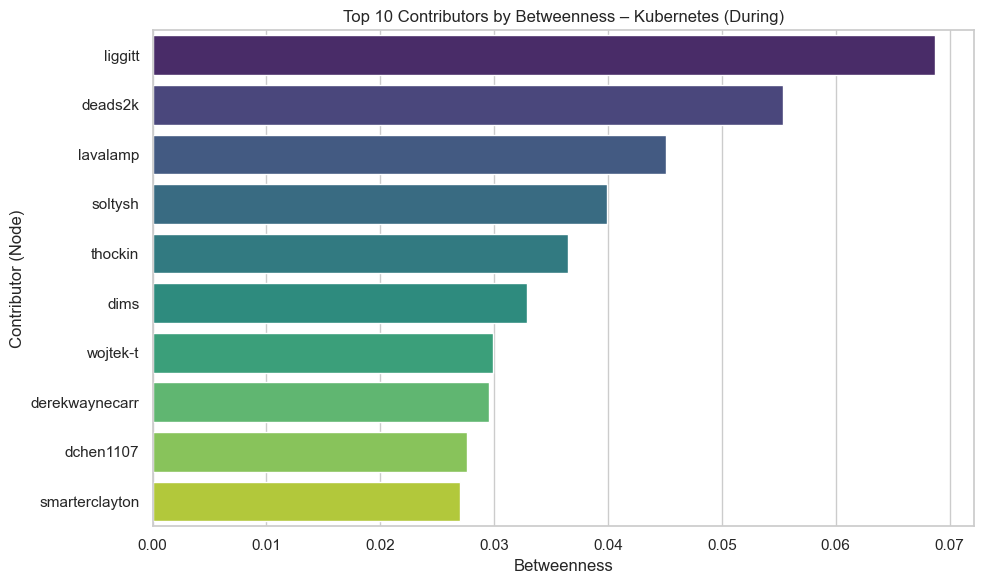

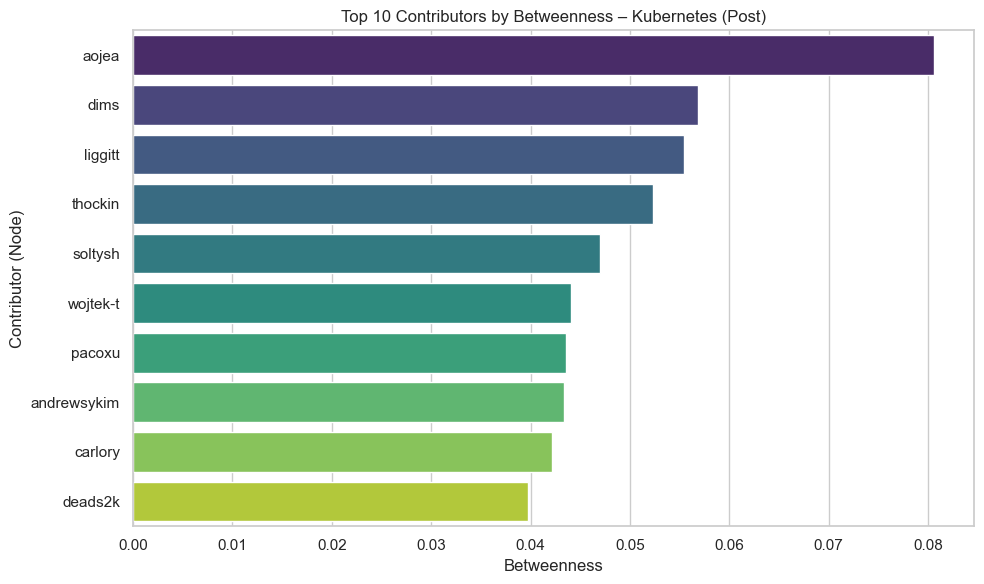

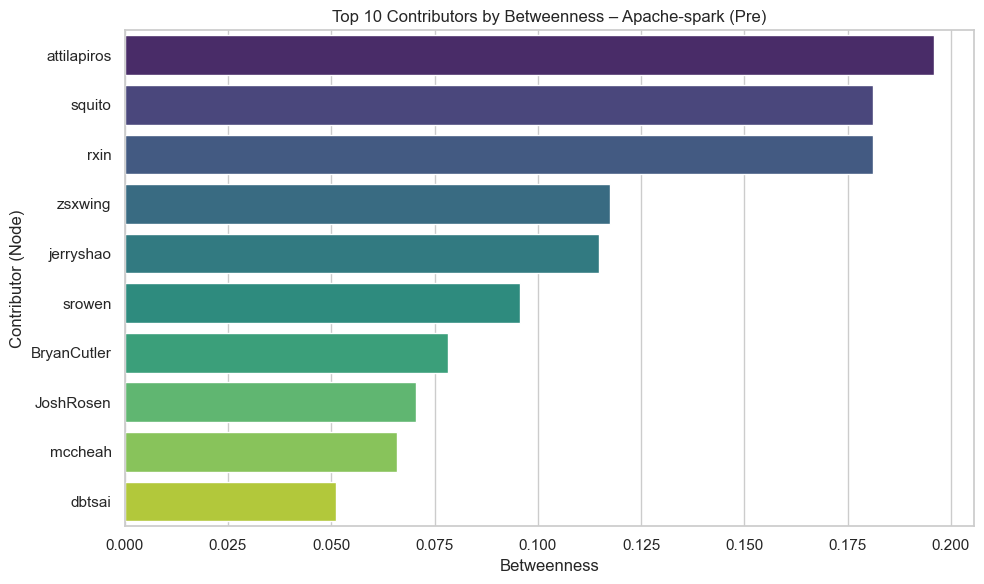

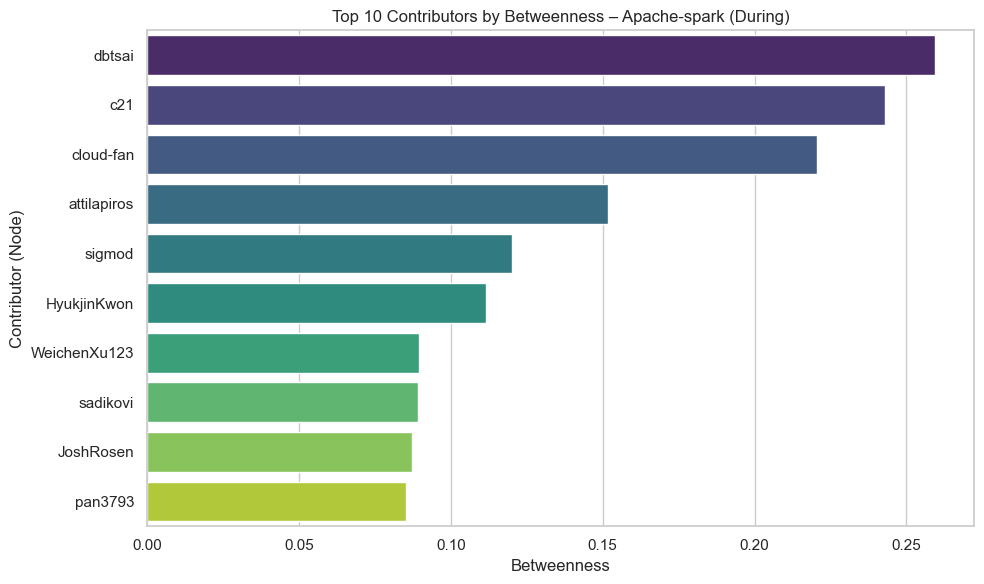

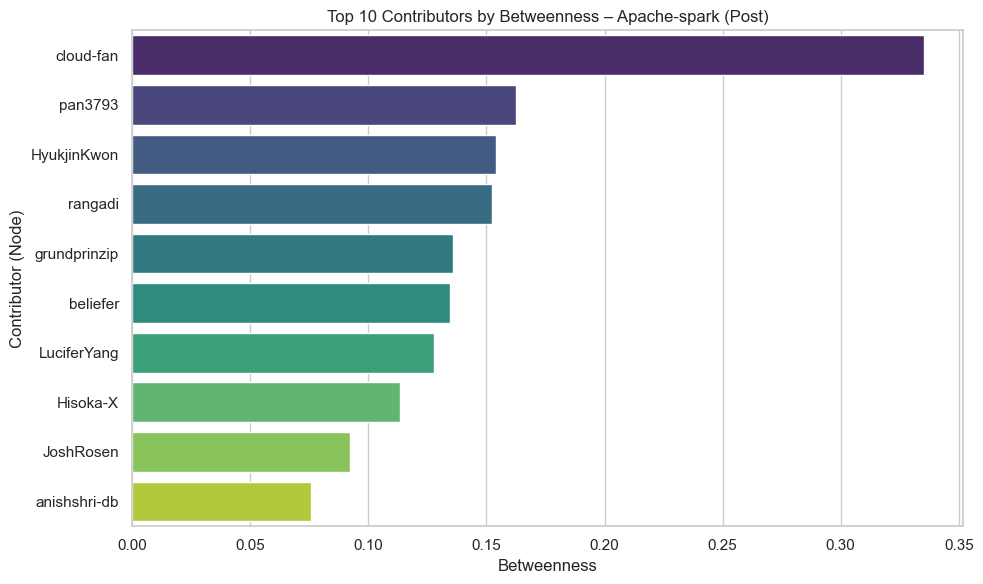

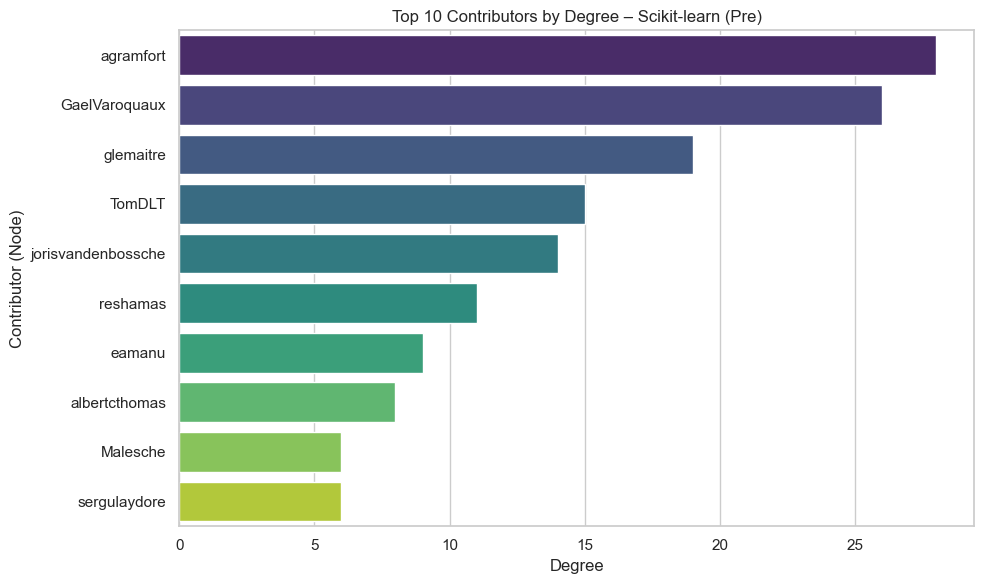

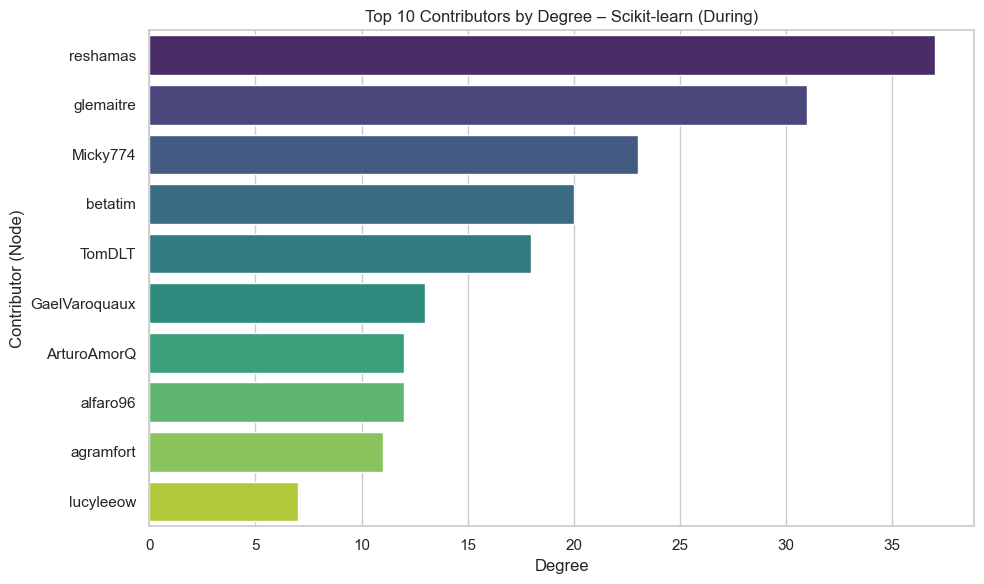

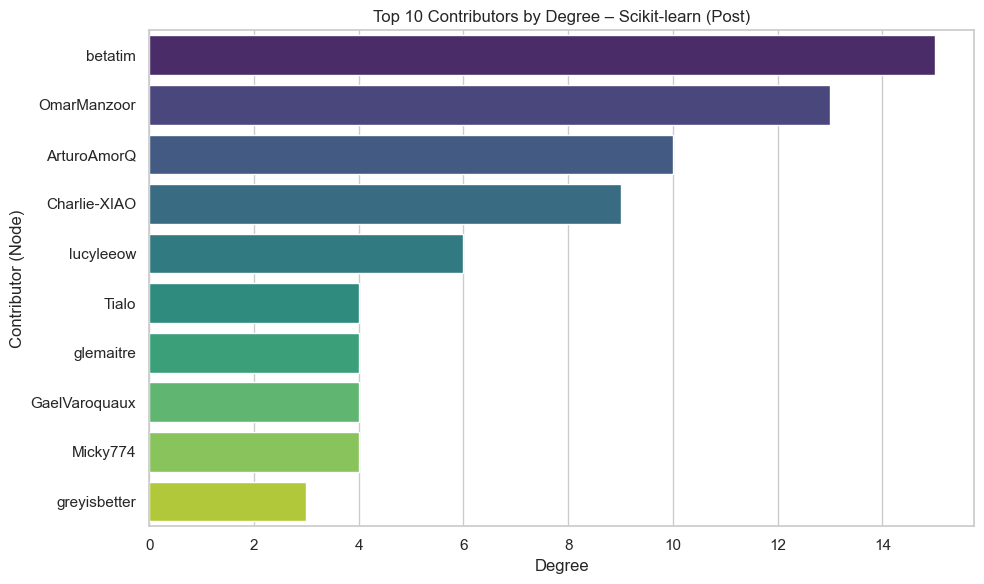

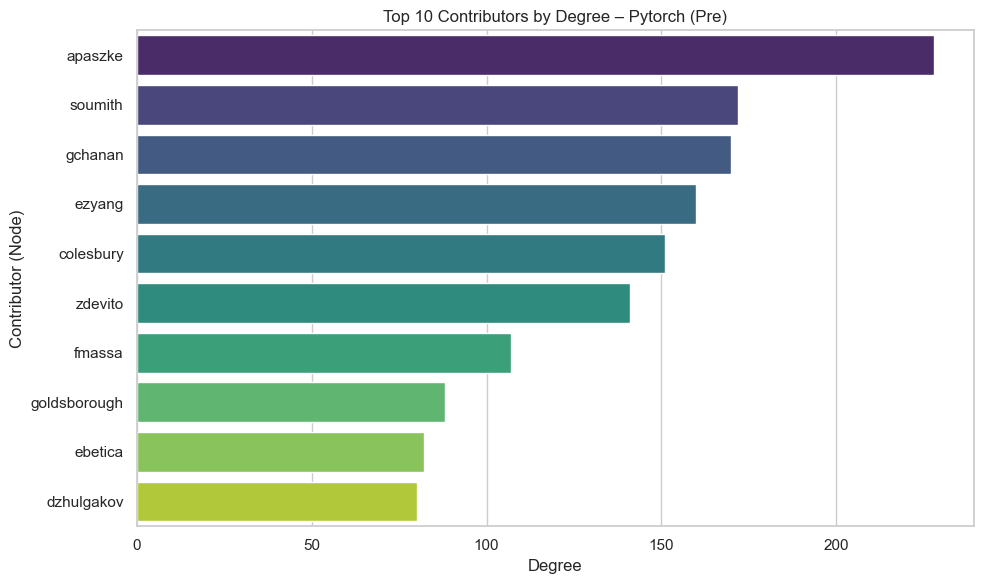

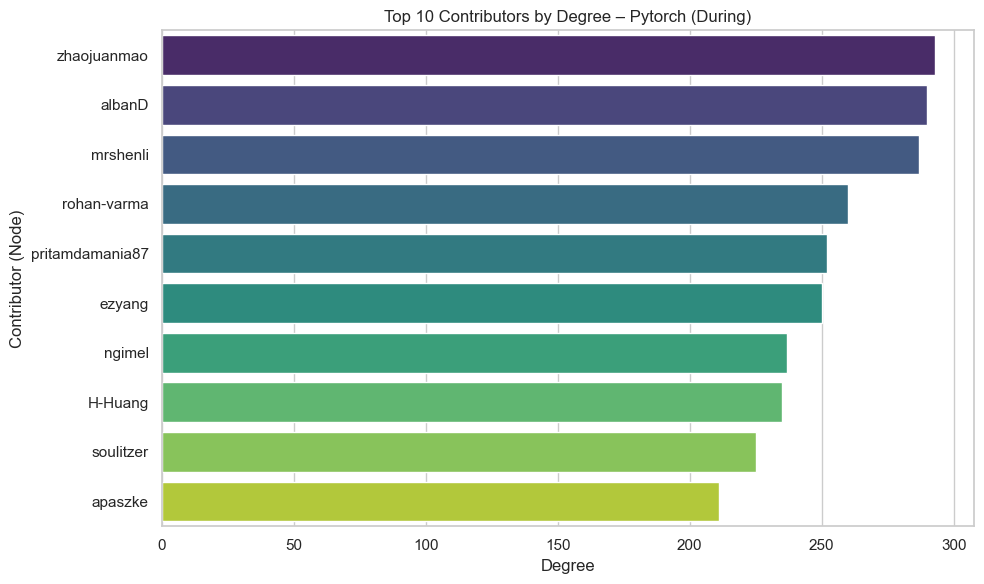

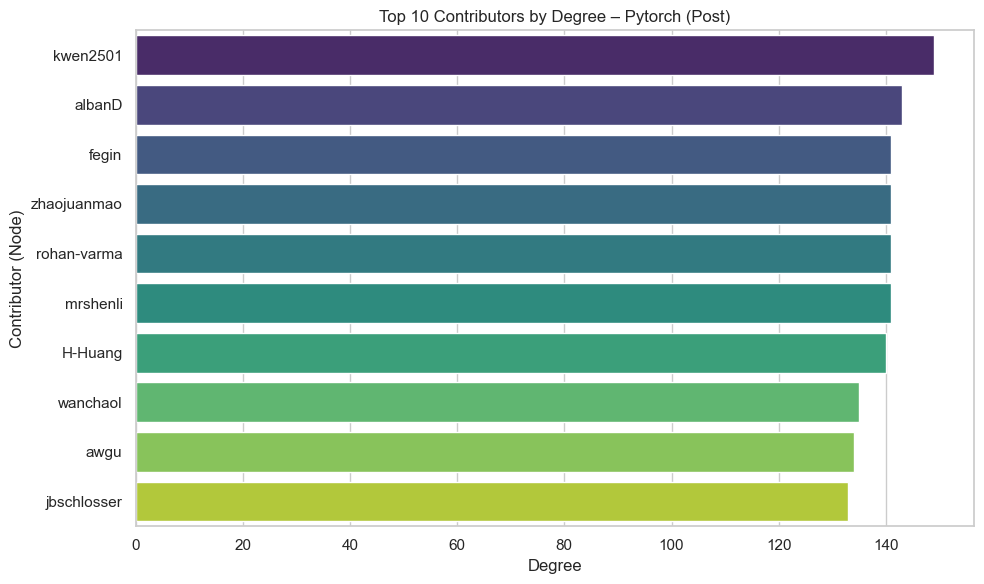

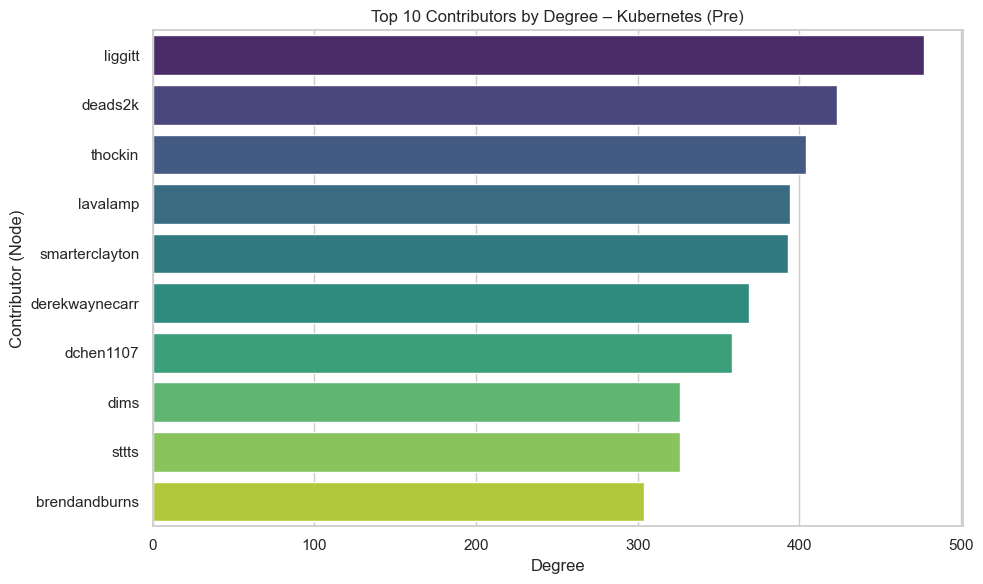

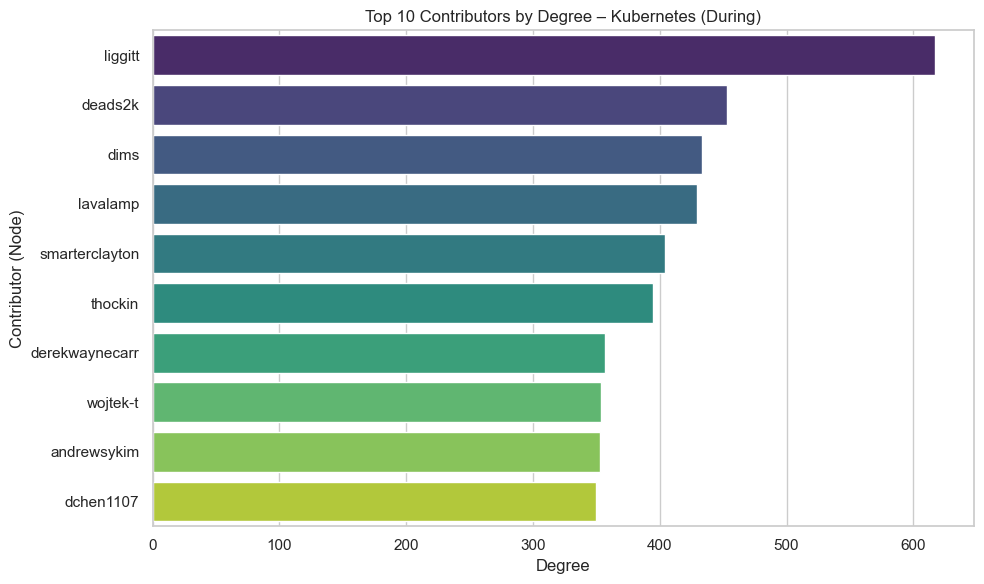

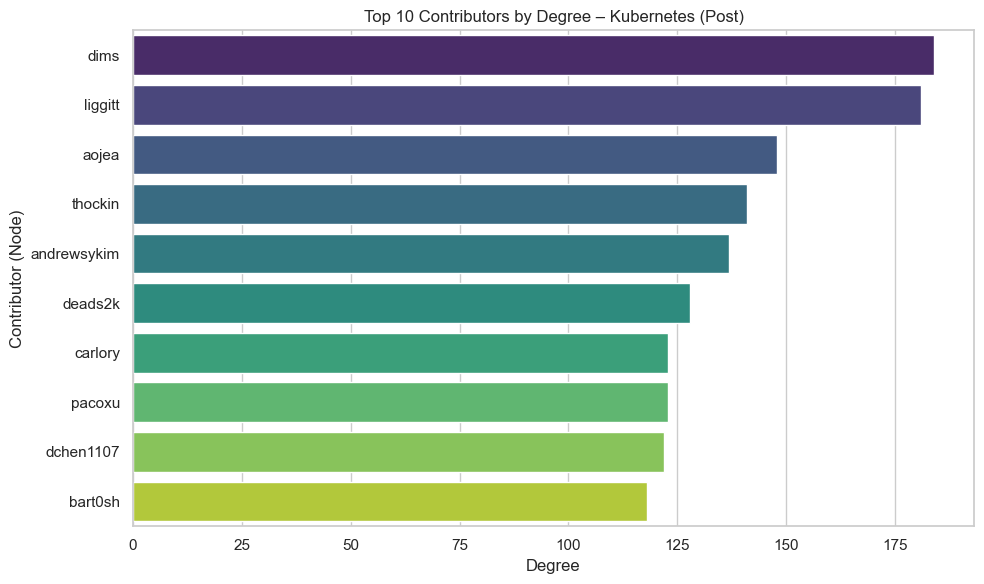

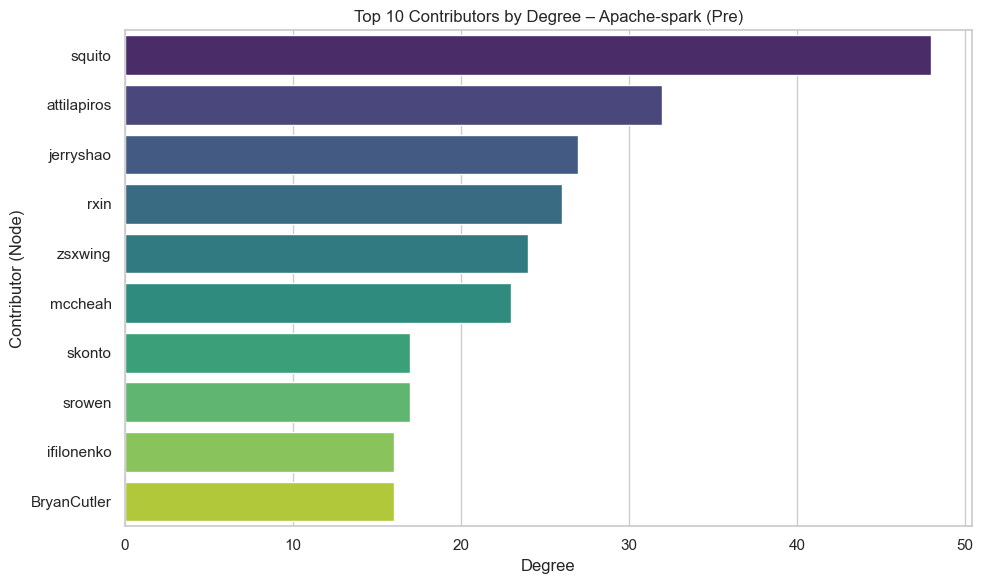

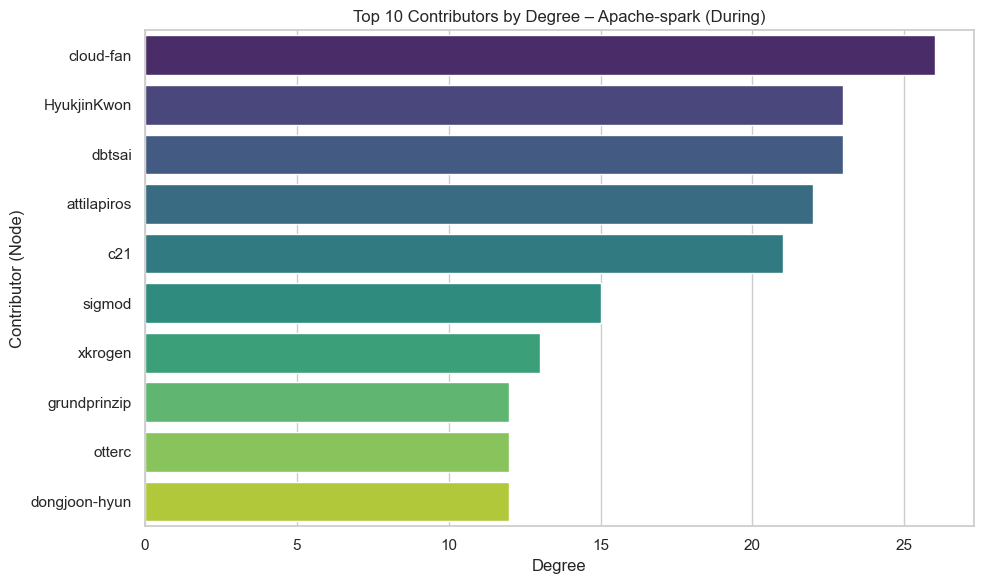

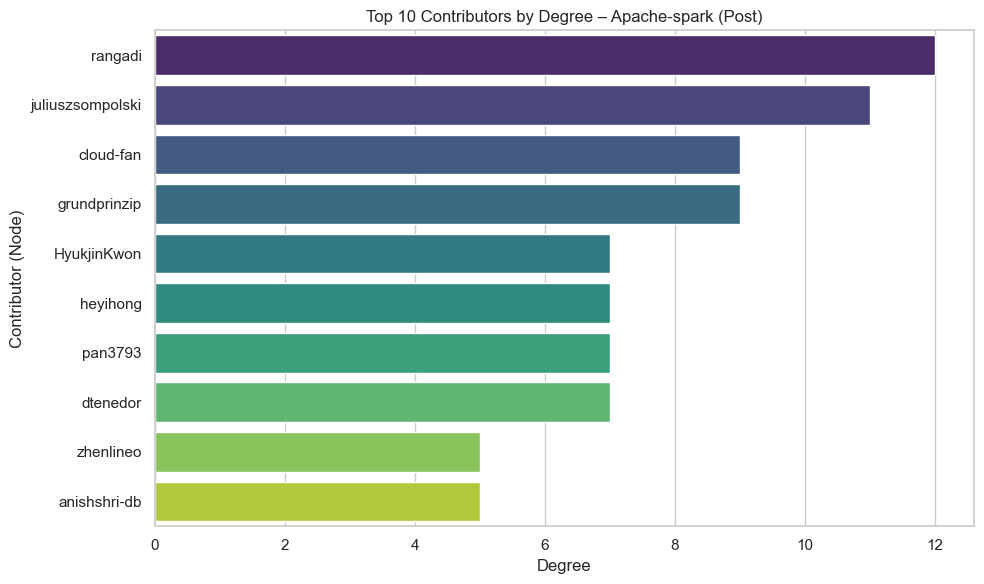

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
node_df = pd.read_csv("../data/results/node_metrics.csv")

# Ensure consistent capitalization
node_df["phase"] = node_df["phase"].str.lower()
node_df["repo"] = node_df["repo"].str.lower()

# Define the metrics you want to visualize
metrics = ["strength", "betweenness", "degree"]

# Plotting function
def plot_top_contributors(df, metric, top_n=10):
    for repo in df["repo"].unique():
        for phase in df["phase"].unique():
            subset = df[(df["repo"] == repo) & (df["phase"] == phase)]

            if subset.empty:
                continue  # Skip empty combinations

            top_nodes = subset.nlargest(top_n, metric)

            plt.figure(figsize=(10, 6))
            sns.barplot(data=top_nodes, x=metric, y="node", palette="viridis")
            plt.title(f"Top {top_n} Contributors by {metric.capitalize()} – {repo.capitalize()} ({phase.capitalize()})")
            plt.xlabel(metric.capitalize())
            plt.ylabel("Contributor (Node)")
            plt.tight_layout()
            plt.show()

# Generate plots for all metrics
for m in metrics:
    plot_top_contributors(node_df, m)
